### Problem 1: Breakout-v0
The action in this game is to position the paddle right or left. Train a neural net that models the action-value function. Use discount factor = 0.95

### Import

In [1]:
import numpy as np
from collections import deque
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import gym
from google.colab import drive
drive.mount('/content/drive')
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

TensorFlow 1.x selected.
Mounted at /content/drive


### Choose Game

In [2]:
env = gym.make("Breakout-v0")

### Network structure parameters

In [3]:
state_size = [80,80,4]
stack_size = 4
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8),(4,4),(3,3)]
conv_strides = [4,2,1]
conv_paddings = ["SAME"] * 3
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64*10*10
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n
initializer = tf.variance_scaling_initializer()


### Learning rate

In [4]:
learning_rate = 0.001
momentum = 0.95

### Replay memory

In [5]:
replay_memory_size = 500000
replay_memory = deque([], maxlen = replay_memory_size)

### Epsilon greedy

In [6]:
eps_min = 0.1
eps_max = 1
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max - eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action
    

### Training parameters

In [7]:
training_start = 10000 # start training after 10,000 game iterations
save_steps = 1000 # save the model every 1000 steps
copy_steps = 10000 # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.95
batch_size = 50
iteration = 0 # game iterations
#checkpoint_path = "./p1/my_dqn_ckpt"
checkpoint_path = "/content/drive/My Drive/p1/my_dqn_ckpt"
done = True # env needs to be reset


### Functions

In [8]:
def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else just set to 1
    return np.reshape(image.astype(np.float).ravel(), [80,80])

stacked_frames = deque([np.zeros((80,80), dtype = np.float32) for i in range(stack_size)], maxlen = stack_size)
def stack_frames(stacked_frames, state, is_new_episode):
    frame = preprocess(state)

    if is_new_episode:
        stacked_frames = deque([np.zeros((80,80), dtype = np.float32) for i in range(stack_size)], maxlen = stack_size)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        # stack the frames
        stacked_states = np.stack(stacked_frames, axis=2)

    else:
        stacked_frames.append(frame)
        stacked_states = np.stack(stacked_frames, axis=2)

    return stacked_states, stacked_frames

class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape = maxlen, dtype = np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size = batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

    
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

### Construction

In [9]:
def q_network(X_state,name):
    prev_layer = X_state/128.0 # scale pixel intensities to the [-1.0, 1.0] range
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
            conv_n_maps, conv_kernel_sizes, conv_strides, conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters = n_maps, 
                kernel_size = kernel_size,
                strides = strides,
                padding = padding,
                activation = activation,
                kernel_initializer = initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        #last_conv_layer_flat = tf.contrib.layers.flatten(prev_layer)
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden, activation = hidden_activation,
                               kernel_initializer = initializer)
        outputs = tf.layers.dense(hidden, n_outputs, kernel_initializer = initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                      scope = scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var for var in trainable_vars}
    return outputs, trainable_vars_by_name

# Reset the graph
tf.reset_default_graph()
X_state = tf.placeholder(tf.float32, shape = [None, *state_size])
online_q_values, online_vars = q_network(X_state, name = "q_neworks/online")
target_q_values, target_vars = q_network(X_state, name = "q_neworks/target")

copy_ops = [target_var.assign(online_vars[var_name]) for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs), axis=1, keepdims=True)
    error = tf.abs(y-q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)
    
    global_step = tf.Variable(0, trainable=False, name="global_step")
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
            

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Variables to keep track of progress

In [10]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0
all_mean_max_q = []

### Execution

In [12]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    
    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)

    while True:
        step = global_step.eval()
        iteration += 1
      
        print("\rIteration {}\tTraining steps {}\tLoss {:5f}\tMean Max-Q {:5f}  ".format(
            iteration, step, loss_val, mean_max_q), end="")
        if done:
            state = env.reset()
            state, stacked_frames = stack_frames(stacked_frames, state, True)
        
        # Online DNQ evaluation what to do
        q_values = online_q_values.eval(feed_dict = {X_state: state.reshape(1, *state_size)})
        action = epsilon_greedy(q_values, step)
        
        # Online DQN plays
        next_state, reward, done, info = env.step(action)
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
    
        
        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0-done))
        state = next_state
        
        # Compute statistics for tracking progress
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            all_mean_max_q.append(mean_max_q)
            total_max_q = 0.0
            game_length = 0
        
        if iteration < training_start:
            continue # Only train after warmup period
            
        # Sample memories and use the target DQN to product the target Q-value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict = {X_state: X_next_state_val.reshape(batch_size, *state_size)})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values
        
        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val.reshape(batch_size, *state_size), X_action: X_action_val, y: y_val})
        
        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()
          
        # Save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)
            with open('/content/drive/My Drive/p1/p1.txt', "a") as output:
                      output.write(str(str(all_mean_max_q) + "\n"))
            
            all_mean_max_q = []

        

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/p1/my_dqn_ckpt
Iteration 11125	Training steps 1578126	Loss 0.000020	Mean Max-Q 0.145859  

KeyboardInterrupt: ignored

i) Plot (average) maximum of the Q function versus iteration to track progress of your network.

Since the kernel was interrupted several times, the data of the previous mean_max_q was lost, and I'm not sure how long it was actually trained. But from the plot below, we can see that the model is improving. 

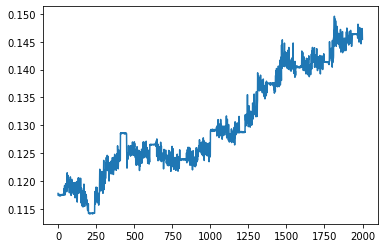

In [8]:
plt.plot(all_mean_max_q)
plt.show()

ii) After training your neural network for 24 hours, play 1000 games using your trained neural network and
plot the sum of rewards in each game (no discounting here).

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/p1/my_dqn_ckpt


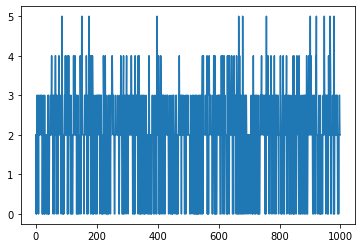

In [14]:
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    rewards_all = []
    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)
    rewards = 0
    step = 0
    games = 0
    steps = []
    infos = []
    while games < 1000:
        q_values = online_q_values.eval(feed_dict = {X_state: state.reshape(1, *state_size)})
        action = np.argmax(q_values)
        state, reward, done, info = env.step(action)
        state, stacked_frames = stack_frames(stacked_frames, state, False)
        rewards += reward
        step += 1
        infos.append(info)
        if done:
            steps.append(step)
            games += 1
            state = env.reset()
            state, stacked_frames = stack_frames(stacked_frames, state, True)
            rewards_all.append(rewards)
            rewards = 0
            step = 0
                
    plt.plot(rewards_all)
    plt.show()